# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.037090,True,5.376776
1,0.202380,False,0.707057
2,-2.041607,False,-6.256731
3,-0.073407,False,-0.539406
4,-0.448471,False,-1.061783
...,...,...,...
995,0.404990,True,5.789682
996,0.134869,True,4.422475
997,1.377515,True,8.933273
998,0.364984,True,7.419739


<AxesSubplot: xlabel='v0'>

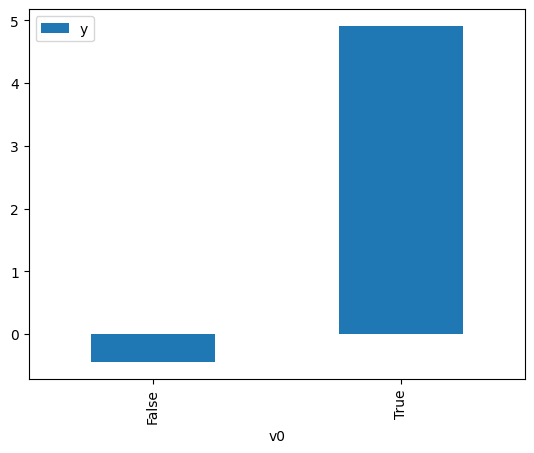

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

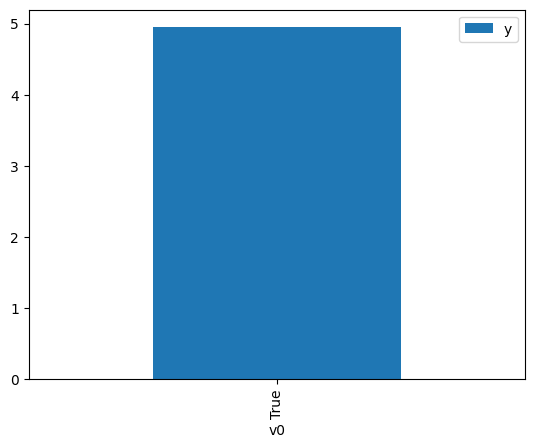

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.032941,False,-0.489662,0.501540,1.993860
1,1.158850,False,2.054903,0.088966,11.240190
2,-0.132759,False,-1.659307,0.550209,1.817491
3,0.607163,False,1.176051,0.223289,4.478501
4,-0.073407,False,-0.539406,0.521326,1.918186
...,...,...,...,...,...
995,0.780855,False,0.844283,0.169871,5.886805
996,0.407551,False,0.892933,0.298189,3.353581
997,0.255098,False,1.253909,0.364110,2.746422
998,-1.255596,False,-4.688930,0.916754,1.090805


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.138288,True,3.954274,0.102527,9.753514
1,0.699254,True,7.624528,0.806408,1.240067
2,-0.481218,True,2.007632,0.292455,3.419328
3,-0.938561,True,4.273024,0.144480,6.921358
4,-0.539439,True,3.806338,0.269446,3.711321
...,...,...,...,...,...
995,-0.303823,True,4.161955,0.369047,2.709681
996,-0.800226,True,2.208560,0.181261,5.516907
997,-1.785215,True,-0.654902,0.031202,32.049106
998,-0.400513,True,4.031002,0.326174,3.065846


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                          1.162e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):                        0.00
Time:                        16:03:35   Log-Likelihood:                         -1395.7
No. Observations:                1000   AIC:                                      2795.
Df Residuals:                     998   BIC:                                      2805.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2348      0.033     67.015      0.000       2.169       2.300
x2             4.9849      0.048    104.002      0.000       4.891       5.079
==============================================================================
Omnibus:                        1.699   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                1.607
Skew:                          -0.009   Prob(JB):                        0.448
Kurtosis:                       2.804   Cond. No.                         1.69
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""